In [170]:
from functools import partial
import numpy as np
import h5py
from unyt import Msun, Myr, Angstrom, erg, s, Hz, yr, h
from astropy.cosmology import LambdaCDM
import pandas as pd
from astropy.io import fits
from schwimmbad import MultiPool
from uncertainties import unumpy

from synthesizer.grid import Grid
from synthesizer.particle import Galaxy
from synthesizer.instruments.filters import FilterCollection

from synthesizer.emission_models import PacmanEmission, BimodalPacmanEmission
from synthesizer.emission_models.attenuation import PowerLaw, Calzetti2000, GrainsWD01
from synthesizer.emissions.utils import (
    Ha,
    Hb, 
    O2b,
    O2r,
    O3r,
    O3b,
    O3,
)
from synthesizer.conversions import lnu_to_absolute_mag

np.random.seed(680010)

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from utilities import binned_weighted_quantile, calc_line_corr, calc_line_corr_from_Av

cosmo = LambdaCDM(Om0=0.307, Ode0=0.693, H0=67.77, Ob0=0.04825)

In [171]:
def get_data(ii, tag):

    num = str(ii)

    if len(num) == 1:
        num =  '0'+num

    sim = "./data/flares_sfe_data.hdf5"
    num = num+'/'

    with h5py.File(sim, 'r') as hf:
        Mstar   = np.array(hf[num+tag+'/Galaxy/Mstar_aperture'].get('30'), dtype = np.float32)*1e10
        MassweightedZ = np.array(hf[num+tag+'/Galaxy/Metallicity'].get('CurrentMassWeightedStellarZ'), dtype = np.float32)
        MFUVatt = np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Luminosity/DustModelI'].get('FUV'), dtype = np.float32) * erg / s / Hz
        MFUVint = np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Luminosity/Intrinsic'].get('FUV'), dtype = np.float32) * erg / s / Hz
        MFUVstel = np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Luminosity/Pure_Stellar'].get('FUV'), dtype = np.float32) * erg / s / Hz

        Av = np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Luminosity/DustModelI'].get('V'), dtype = np.float32) / np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Luminosity/Intrinsic'].get('V'), dtype = np.float32)
        Av = -2.5 * np.log10(Av)

        Halpha = np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Lines/DustModelI/HI6563'].get('Luminosity'), dtype = np.float64)
        Hbeta = np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Lines/DustModelI/HI4861'].get('Luminosity'), dtype = np.float64)
        Halphaint = np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Lines/Intrinsic/HI6563'].get('Luminosity'), dtype = np.float64)
        Hbetaint = np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Lines/Intrinsic/HI4861'].get('Luminosity'), dtype = np.float64)      
        
        ion_ppe = np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Indices'].get('IonisingPPE'), dtype = np.float64) 

    ok = (Halphaint>0) * (Mstar>1e8)

    return Mstar[ok], MFUVatt[ok], Halpha[ok], Hbeta[ok], Halphaint[ok], Hbetaint[ok], MassweightedZ[ok], ion_ppe[ok], MFUVint[ok], MFUVstel[ok], Av[ok]

In [172]:
# Define the grid
grid_name = "bpass-2.2.1-bin_chabrier03-0.1,300.0_cloudy-c23.01-sps"
grid_dir = "./data/" 
grid = Grid(grid_name, grid_dir=grid_dir)

Zsun = 0.014
req_lines = {'H 1 6562.80A': 'Halpha',
             'H 1 4861.32A': 'Hbeta',
             'O 2 3726.03A,O 2 3728.81A': '[OII]3727,29',
             'O 3 4958.91A': '[OIII]4959',
             'O 3 5006.84A': '[OIII]5007',
             'Ne 3 3868.76A': 'NeIII3869'
}

tophats = {
    "UV1500": {"lam_eff": 1500*Angstrom, "lam_fwhm": 300*Angstrom},
    "UV2800": {"lam_eff": 2800*Angstrom, "lam_fwhm": 300*Angstrom},
}

filters = FilterCollection(
    filter_codes=[f'Generic/Johnson.V'],
    tophat_dict=tophats,
    new_lam=grid.lam
)

li = [
       Ha,
       Hb, 
   ]

lam_Ha = 6562.80 * Angstrom
lam_Hb = 4861.32 * Angstrom

In [173]:
redshift = 6.
# Number of star particles
n = 100
ages = np.random.uniform(1, 30, size=n) * Myr
Z = 10**np.random.uniform(-3, -2, size=n)
mass = 1e6*np.random.uniform(1, 5, n) * Msun 

# Dust distributions
max_tau = 15
mu, sigma = 0.1, 0.2
nsigma = np.arange(0,max_tau,2)
num_gals = len(nsigma)


# Property holders
logOH = np.zeros(4)
lum_int = np.zeros(4, dtype=object)
line_int = np.zeros(4, dtype=object)
sed_int = np.zeros(4, dtype=object)

line_emergent = np.zeros((4, num_gals), dtype=object)
sed_emergent = np.zeros((4, num_gals), dtype=object)
lum_att = np.zeros((4, num_gals))
Av = np.zeros((4, num_gals))
att_curve = np.zeros((4, num_gals, len(grid.lam)))
#Incident and intrinsic
Luv = np.zeros((2, 4))
Luv_att = np.zeros((4, num_gals))

gal_ippe_Ha = np.zeros((4, num_gals))
gal_ippe_Hb = np.zeros((4, num_gals))
gal_ippe_decrement_Ha = np.zeros((4, num_gals))
gal_ippe_decrement_Hb = np.zeros((4, num_gals))
i_ppe_sed = np.zeros(4)
i_ppe_Ha = np.zeros(4)
i_ppe_Hb = np.zeros(4)

# Vary everything
gal = Galaxy(redshift=redshift)
gal.load_stars(
    ages=ages,
    metallicities=Z,
    initial_masses=mass 
)
ok = gal.stars.ages<=10*Myr
Zmean = np.sum(gal.stars.initial_masses[ok] * gal.stars.metallicities[ok]) / np.sum(gal.stars.initial_masses[ok])
Agemean = np.sum(gal.stars.initial_masses[ok] * gal.stars.ages[ok]) / np.sum(gal.stars.initial_masses[ok])

print (Zmean, Agemean)

# Keep everything fixed
gal_const = Galaxy(redshift=redshift)
gal_const.load_stars(
    ages=np.ones(n) * Agemean,
    metallicities=np.ones(n) * Zmean,
    initial_masses=mass 
)

# Vary age
gal_vary_age = Galaxy(redshift=redshift)
gal_vary_age.load_stars(
    ages=ages,
    metallicities=np.ones(n) * Zmean,
    initial_masses=mass 
)

# Vary metallicity
gal_vary_Z = Galaxy(redshift=redshift)
gal_vary_Z.load_stars(
    ages=np.ones(n) * Agemean,
    metallicities=Z,
    initial_masses=mass 
)

all_gals = [gal_const, gal_vary_age, gal_vary_Z, gal]

for jj, kk in enumerate(all_gals):
    print ("Galaxy number: ", jj)
    ok = kk.stars.ages<=10*Myr
    Zmean = np.sum(kk.stars.initial_masses[ok] * kk.stars.metallicities[ok]) / np.sum(kk.stars.initial_masses[ok])    
    logOH[jj] = 8.69 + np.log10(Zmean/Zsun)

    for ii in range(num_gals):
        tau_v = mu + np.random.normal(0, nsigma[ii], n)
        tau_v[tau_v<0] = 0.01
        emodel = PacmanEmission(
            grid=grid,
            tau_v=tau_v,
            dust_curve=PowerLaw(),
            per_particle=True
        )    
    
    
        kk.stars.get_spectra(emission_model=emodel)    
        kk.stars.get_lines(li,
            emodel
        )   
        
        
        line_emergent[jj][ii] = kk.stars.lines['emergent']
        
        sed_emergent[jj][ii] = kk.stars.spectra['emergent']
        att_curve[jj][ii] = -2.5 * np.log10(kk.stars.spectra['emergent'].luminosity/kk.stars.spectra['intrinsic'].luminosity)
        kk.stars.spectra['emergent'].get_fnu(cosmo=cosmo, z=redshift)   
        tmp = kk.stars.spectra['emergent'].get_photo_lnu(filters, verbose=False)
        lum_att[jj][ii] = tmp['Generic/Johnson.V']
        Luv_att[jj][ii] = tmp['UV1500']

    line_int[jj] = kk.stars.lines['intrinsic']    
    sed_int[jj] = kk.stars.spectra['intrinsic']
    lum_int[jj] = kk.stars.spectra['intrinsic'].get_photo_lnu(filters, verbose=False)['Generic/Johnson.V']
    
    Luv[0][jj] = kk.stars.spectra['incident'].get_photo_lnu(filters, verbose=False)['UV1500'] 
    Luv[1][jj] = kk.stars.spectra['intrinsic'].get_photo_lnu(filters, verbose=False)['UV1500'] 
    ok = (grid.lam<=912*Angstrom)
    i_ppe_sed[jj] = -np.trapz(y=kk.stars.spectra['incident'].lnu[ok] / (h.to('erg*s') * kk.stars.spectra['incident'].nu[ok]), x = kk.stars.spectra['incident'].nu[ok]) / Luv[1][jj]
    i_ppe_Ha[jj] = line_int[jj]['Ha'].luminosity / (1.36e-12 * Luv[1][jj])
    i_ppe_Hb[jj] = line_int[jj]['Hb'].luminosity / (4.87e-13 * Luv[1][jj])

    Av[jj] = -2.5 * np.log10(lum_att[jj]/lum_int[jj])


for jj, kk in enumerate(all_gals):
    for ii in range(num_gals):
        gal_ippe_Ha[jj][ii] = calc_line_corr_from_Av(line_emergent[jj][ii]['Ha'].luminosity, lam_Ha, Av[jj][ii], slope=0) / (1.36e-12 * calc_line_corr_from_Av(Luv_att[jj][ii], 1500*Angstrom, Av[jj][ii], slope=0))
        
        gal_ippe_Hb[jj][ii] = calc_line_corr_from_Av(line_emergent[jj][ii]['Hb'].luminosity, lam_Hb, Av[jj][ii], slope=0) / (4.87e-13 * calc_line_corr_from_Av(Luv_att[jj][ii], 1500*Angstrom, Av[jj][ii], slope=0))
        
        gal_ippe_decrement_Ha[jj][ii] = calc_line_corr(line_emergent[jj][ii]['Ha'].luminosity, lam_Ha, line_emergent[jj][ii]['Ha'].luminosity/line_emergent[jj][ii]['Hb'].luminosity) / (1.36e-12 * calc_line_corr(Luv_att[jj][ii], 1500*Angstrom, line_emergent[jj][ii]['Ha'].luminosity/line_emergent[jj][ii]['Hb'].luminosity))
        
        gal_ippe_decrement_Hb[jj][ii] = calc_line_corr(line_emergent[jj][ii]['Hb'].luminosity, lam_Hb, line_emergent[jj][ii]['Ha'].luminosity/line_emergent[jj][ii]['Hb'].luminosity) / (4.87e-13 * calc_line_corr(Luv_att[jj][ii], 1500*Angstrom, line_emergent[jj][ii]['Ha'].luminosity/line_emergent[jj][ii]['Hb'].luminosity))


/Users/ap629AA/Astro/synthesizer/synthesizer/src/synthesizer/particle/galaxy.py:260: RuntimeWarning: Current mass of stars not provided, setting stellar_mass_weighted_age to `None`
  self.calculate_integrated_stellar_properties()
/Users/ap629AA/pyvenv/astro_venv/lib/python3.12/site-packages/unyt/array.py:1949: RuntimeWarning: invalid value encountered in divide
  out_arr = func(


0.0043673333344749635 dimensionless 5268099.2695223 yr
Galaxy number:  0


/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_6800/3789084498.py:116: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  i_ppe_sed[jj] = -np.trapz(y=kk.stars.spectra['incident'].lnu[ok] / (h.to('erg*s') * kk.stars.spectra['incident'].nu[ok]), x = kk.stars.spectra['incident'].nu[ok]) / Luv[1][jj]
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_6800/3789084498.py:117: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  i_ppe_Ha[jj] = line_int[jj]['Ha'].luminosity / (1.36e-12 * Luv[1][jj])
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_6800/3789084498.py:118: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single eleme

Galaxy number:  1
Galaxy number:  2
Galaxy number:  3


/Users/ap629AA/pyvenv/astro_venv/lib/python3.12/site-packages/unyt/array.py:1824: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_6800/3789084498.py:125: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gal_ippe_Ha[jj][ii] = calc_line_corr_from_Av(line_emergent[jj][ii]['Ha'].luminosity, lam_Ha, Av[jj][ii], slope=0) / (1.36e-12 * calc_line_corr_from_Av(Luv_att[jj][ii], 1500*Angstrom, Av[jj][ii], slope=0))
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_6800/3789084498.py:127: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 

<>:42: SyntaxWarning: invalid escape sequence '\m'
<>:42: SyntaxWarning: invalid escape sequence '\m'
<>:42: SyntaxWarning: invalid escape sequence '\m'
<>:42: SyntaxWarning: invalid escape sequence '\m'
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_6800/3009552292.py:42: SyntaxWarning: invalid escape sequence '\m'
  twinax.legend(custom, [r'Varying only A$_{\mathrm{V}}$', 'Varying A$_{\mathrm{V}}$ and ages', 'Varying A$_{\mathrm{V}}$ and Z', 'Varying all'], frameon=True, fontsize=11, loc="lower left")
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_6800/3009552292.py:42: SyntaxWarning: invalid escape sequence '\m'
  twinax.legend(custom, [r'Varying only A$_{\mathrm{V}}$', 'Varying A$_{\mathrm{V}}$ and ages', 'Varying A$_{\mathrm{V}}$ and Z', 'Varying all'], frameon=True, fontsize=11, loc="lower left")


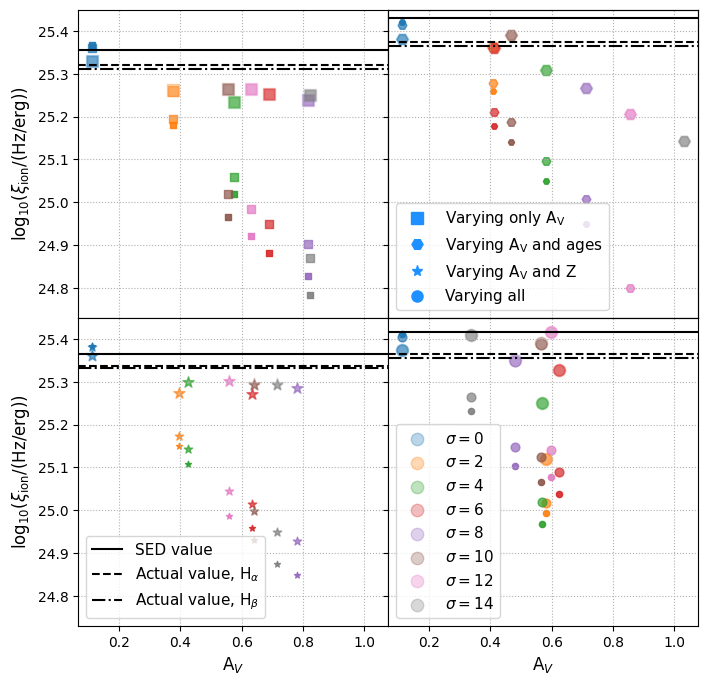

In [174]:
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize=(8, 8), sharex=True, sharey=True, facecolor='w', edgecolor='k')
axs = axs.ravel()
twinax = axs[1].twinx()

markers = ['s', 'H', '*', 'o']
custom = [Line2D([], [], marker=ii, markersize=8, color='dodgerblue', linestyle='None') for ii in markers]

for jj, ax in enumerate(axs):
    if jj==2:
        ax.axhline(y=np.log10(i_ppe_sed[jj]), label='SED value', color='black')
        ax.axhline(y=np.log10(i_ppe_Ha[jj]), label=r'Actual value, H$_{\alpha}$', color='black', ls='dashed')
        ax.axhline(y=np.log10(i_ppe_Hb[jj]), label=r'Actual value, H$_{\beta}$', color='black', ls='dashdot')
    else:
        ax.axhline(y=np.log10(i_ppe_sed[jj]), color='black')
        ax.axhline(y=np.log10(i_ppe_Ha[jj]), color='black', ls='dashed')
        ax.axhline(y=np.log10(i_ppe_Hb[jj]), color='black', ls='dashdot')

    for ii in range(num_gals):
        color = plt.cm.tab10(ii)        
        
        ax.scatter(Av[jj][ii], np.log10(gal_ippe_Ha[jj][ii]), color=color, s=20, marker=markers[jj], alpha=0.9)
            
        ax.scatter(Av[jj][ii], np.log10(gal_ippe_Hb[jj][ii]), color=color, s=40, marker=markers[jj], alpha=0.7)
        
        ax.scatter(Av[jj][ii], np.log10(gal_ippe_decrement_Ha[jj][ii]), color=color, s=60, marker=markers[jj], alpha=0.5)
        
        if jj==3:
            ax.scatter(Av[jj][ii], np.log10(gal_ippe_decrement_Hb[jj][ii]), color=color, s=80, marker=markers[jj], alpha=0.3, label=rF'$\sigma={nsigma[ii]}$')
        else:
            ax.scatter(Av[jj][ii], np.log10(gal_ippe_decrement_Hb[jj][ii]), color=color, s=80, marker=markers[jj], alpha=0.3)
        
    ax.grid(ls='dotted')
    ax.set_ylim(24.73, 25.45)
        
axs[2].set_xlabel(r'A$_{V}$', fontsize=12)
axs[3].set_xlabel(r'A$_{V}$', fontsize=12)
axs[0].set_ylabel(r'log$_{10}$($\xi_{\rm ion}$/(Hz/erg))', fontsize=12)
axs[2].set_ylabel(r'log$_{10}$($\xi_{\rm ion}$/(Hz/erg))', fontsize=12)

axs[3].legend(frameon=True, fontsize=11, loc='lower left') 
axs[2].legend(frameon=True, fontsize=11, loc='lower left') 
twinax.legend(custom, [r'Varying only A$_{\mathrm{V}}$', 'Varying A$_{\mathrm{V}}$ and ages', 'Varying A$_{\mathrm{V}}$ and Z', 'Varying all'], frameon=True, fontsize=11, loc="lower left")
twinax.set_yticks([])
twinax.set_yticklabels([])
fig.subplots_adjust(hspace=0,wspace=0)
plt.savefig('plots/toy_ion_ppe.png', dpi=300, bbox_inches='tight')
plt.show()   


In [175]:
quantiles = [0.84,0.50,0.16]
Muv_limit = -19.
df = pd.read_csv('./data/weights_grid.txt')
weights = np.array(df['weights'])

tags = ['010_z005p000', '009_z006p000', '008_z007p000', '007_z008p000', '006_z009p000', '005_z010p000']
tag = tags[1]

# a = find_metallicity(R23=9.9, R3=7.2, O32=18.6, hbew=151)

z = float(tag[5:].replace('p','.'))

func    = partial(get_data, tag=tag)
pool    = MultiPool(processes=4)
dat     = np.array(list(pool.map(func, np.arange(0,40))), dtype='object')
pool.close()

Mstar = np.log10(np.concatenate(dat[:,0]))
MFUVatt = np.concatenate(dat[:,1])
Halpha = np.concatenate(dat[:,2])
Hbeta = np.concatenate(dat[:,3])
Halphaint = np.concatenate(dat[:,4])
Hbetaint = np.concatenate(dat[:,5])
MassweightedZ = np.concatenate(dat[:,6])
ion_ppe = np.concatenate(dat[:,7])
MFUVint = np.concatenate(dat[:,8])
MFUVstel = np.concatenate(dat[:,9])
Av = np.concatenate(dat[:,10])

ion_ppe = MFUVstel.to('erg/s/Hz') * ion_ppe / MFUVint.to('erg/s/Hz')

tot_gals = len(Mstar)

ws = np.zeros(tot_gals)
n = 0
for jj in range(40):
    if jj==0:
        ws[0:len(dat[jj][0])] = weights[jj]
    else:
        ws[n:n+len(dat[jj][0])] = weights[jj]

    n+=len(dat[jj][0])

flares_ha_nodust = (Halphaint) / (1.36e-12 * MFUVint.to('erg/s/Hz').to_value())

flares_ha_dustcorr = calc_line_corr_from_Av(Halpha * erg/s, lam_Ha, Av, slope=0).to_value() / (1.36e-12 * calc_line_corr_from_Av(MFUVint.to('erg/s/Hz'), 1500*Angstrom, Av, slope=0).to_value())

flares_ha_dustbalcorr = calc_line_corr(Halpha * erg/s, lam_Ha, Halpha/Hbeta).to_value() / (1.36e-12 * calc_line_corr(MFUVint.to('erg/s/Hz'), 1500*Angstrom, Halpha/Hbeta).to_value())

flares_hb_nodust = (Hbetaint) / (4.87e-13 * MFUVint.to('erg/s/Hz').to_value())

flares_hb_dustcorr = calc_line_corr_from_Av(Hbeta * erg/s, lam_Hb, Av, slope=0).to_value() / (4.87e-13 * calc_line_corr_from_Av(MFUVint.to('erg/s/Hz'), 1500*Angstrom, Av, slope=0).to_value())

flares_hb_dustbalcorr = calc_line_corr(Hbeta * erg/s, lam_Hb, Halpha/Hbeta).to_value() / (4.87e-13 * calc_line_corr(MFUVint.to('erg/s/Hz'), 1500*Angstrom, Halpha/Hbeta).to_value())

/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_6800/3284167008.py:12: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  Mstar   = np.array(hf[num+tag+'/Galaxy/Mstar_aperture'].get('30'), dtype = np.float32)*1e10
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_6800/3284167008.py:12: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  Mstar   = np.array(hf[num+tag+'/Galaxy/Mstar_aperture'].get('30'), dtype = np.float32)*1e10
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvq

In [176]:
quantiles = [0.023,0.50,0.977]
mbins = np.arange(8,11,0.5)
mbincen = (mbins[1:] + mbins[:-1])/2.
yy, yy_low, yy_up = np.zeros((7, len(mbincen))), np.zeros((7, len(mbincen))), np.zeros((7, len(mbincen)))

tmp = binned_weighted_quantile(Mstar, np.log10(ion_ppe), ws, mbins, quantiles)
yy[0], yy_low[0], yy_up[0] = tmp[:,1], tmp[:,0], tmp[:,2]

tmp = binned_weighted_quantile(Mstar, np.log10(flares_ha_nodust), ws, mbins, quantiles)
yy[1], yy_low[1], yy_up[1] = tmp[:,1], tmp[:,0], tmp[:,2]

tmp = binned_weighted_quantile(Mstar, np.log10(flares_ha_dustcorr), ws, mbins, quantiles)
yy[2], yy_low[2], yy_up[2] = tmp[:,1], tmp[:,0], tmp[:,2]

tmp = binned_weighted_quantile(Mstar, np.log10(flares_ha_dustbalcorr), ws, mbins, quantiles)
yy[3], yy_low[3], yy_up[3] = tmp[:,1], tmp[:,0], tmp[:,2]

tmp = binned_weighted_quantile(Mstar, np.log10(flares_hb_nodust), ws, mbins, quantiles)
yy[4], yy_low[4], yy_up[4] = tmp[:,1], tmp[:,0], tmp[:,2]

tmp = binned_weighted_quantile(Mstar, np.log10(flares_hb_dustcorr), ws, mbins, quantiles)
yy[5], yy_low[5], yy_up[5] = tmp[:,1], tmp[:,0], tmp[:,2]

tmp = binned_weighted_quantile(Mstar, np.log10(flares_hb_dustbalcorr), ws, mbins, quantiles)
yy[6], yy_low[6], yy_up[6] = tmp[:,1], tmp[:,0], tmp[:,2]

<>:26: SyntaxWarning: invalid escape sequence '\s'
<>:27: SyntaxWarning: invalid escape sequence '\s'
<>:28: SyntaxWarning: invalid escape sequence '\s'
<>:26: SyntaxWarning: invalid escape sequence '\s'
<>:27: SyntaxWarning: invalid escape sequence '\s'
<>:28: SyntaxWarning: invalid escape sequence '\s'
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_6800/3704603997.py:26: SyntaxWarning: invalid escape sequence '\s'
  axs[3].set_xlabel('log(M$_{\star}$/M$_{\odot}$)', fontsize=12)
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_6800/3704603997.py:27: SyntaxWarning: invalid escape sequence '\s'
  axs[4].set_xlabel('log(M$_{\star}$/M$_{\odot}$)', fontsize=12)
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_6800/3704603997.py:28: SyntaxWarning: invalid escape sequence '\s'
  axs[5].set_xlabel('log(M$_{\star}$/M$_{\odot}$)', fontsize=12)


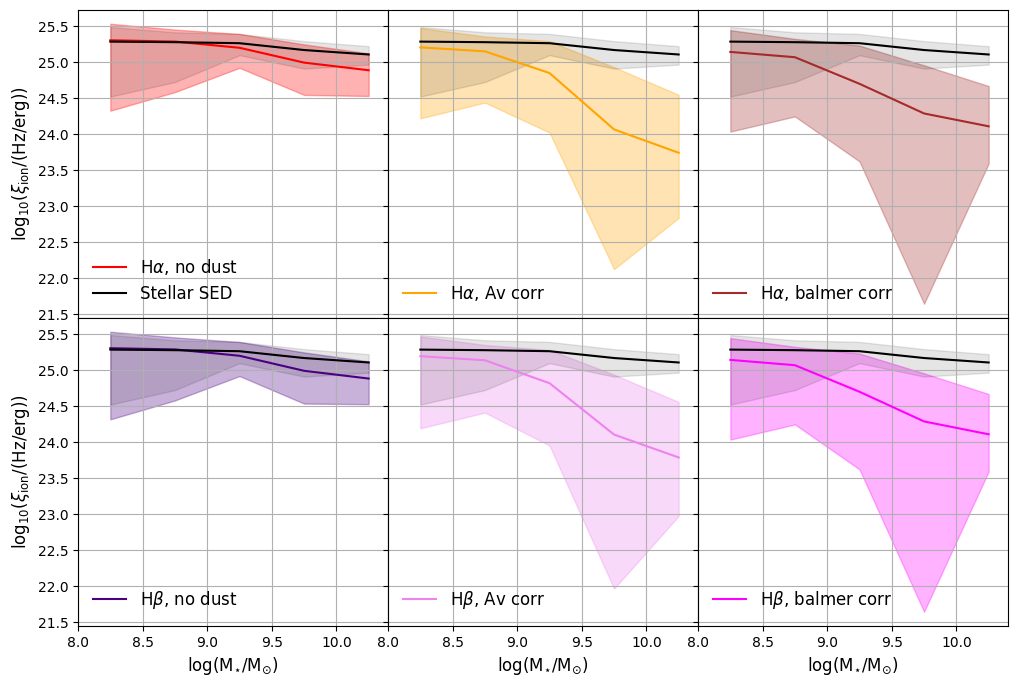

In [177]:
fig, axs = plt.subplots(nrows = 2, ncols = 3, figsize=(12, 8), sharex=True, sharey=True, facecolor='w', edgecolor='k')
axs=axs.ravel()

labels = ['Stellar SED', r'H$\alpha$, no dust', r'H$\alpha$, Av corr', r'H$\alpha$, balmer corr', r'H$\beta$, no dust', r'H$\beta$, Av corr', r'H$\beta$, balmer corr']

colors = ['black', 'red', 'orange', 'brown', 'indigo', 'violet', 'magenta']

for jj in range(6):

    axs[jj].plot(mbincen, yy[jj+1], label=labels[jj+1], color=colors[jj+1])
    axs[jj].fill_between(mbincen, yy_low[jj+1], yy_up[jj+1], color=colors[jj+1], alpha=0.3)
    
    if jj==0:
        axs[jj].plot(mbincen, yy[0], label=labels[0], color=colors[0])
    else:
        axs[jj].plot(mbincen, yy[0], color=colors[0])
    axs[jj].fill_between(mbincen, yy_low[0], yy_up[0], color=colors[0], alpha=0.1)
    
    axs[jj].legend(fontsize=12, frameon=False)
    axs[jj].grid()
    axs[jj].set_xlim(8, 10.4)
    
axs[0].set_ylabel(r'log$_{10}$($\xi_{\rm ion}$/(Hz/erg))', fontsize=12)  
axs[3].set_ylabel(r'log$_{10}$($\xi_{\rm ion}$/(Hz/erg))', fontsize=12)    
    
axs[3].set_xlabel('log(M$_{\star}$/M$_{\odot}$)', fontsize=12)
axs[4].set_xlabel('log(M$_{\star}$/M$_{\odot}$)', fontsize=12)
axs[5].set_xlabel('log(M$_{\star}$/M$_{\odot}$)', fontsize=12)
    
fig.subplots_adjust(hspace=0,wspace=0)
plt.savefig('plots/ion_ppe.png', dpi=300, bbox_inches='tight')